In [2]:
import pickle
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

import covid19sim

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

import sys
sys.path.append("../plots")
from plot_rt import PlotRt
from utils import plot_intervention

In [1]:
filenames_unmitigated = [
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1234_20200508-031803_unmitigated_final.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1235_20200508-031706_unmitigated_final.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1237_20200508-031704_unmitigated_final.pkl"
]

filenames_naive = [
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1234_20200508-054932_naive_final.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1235_20200508-054737_naive_final.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10000_seed_1237_20200508-104703_naive_final.pkl"
]

filenames_transformer = [
    "../src/covid19sim/logs3/tracker_data_n_10002_20200508-013007_transformer.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10002_20200508-013012_transformer.pkl",
    "../src/covid19sim/logs3/tracker_data_n_10002_20200508-013025_transformer.pkl"
]


In [3]:
def plot_line_with_bounds(df, ax, color, label, mobility=False, **kwargs):
    # params
    linestyle = kwargs.get("linestyle", "-")
    alpha = kwargs.get("alpha", 1.0)
    marker = kwargs.get("marker", None)
    markersize = kwargs.get("markersize", 1)
    linewidth = 2
    
    index = np.array(list(range(df.shape[0])))
    mean = df.mean(axis=1)
    lows = mean - 0.95*df.std(axis=1)
    highs = mean + 0.95*df.std(axis=1)
    lowfn = interp1d(index, lows, bounds_error=False, fill_value='extrapolate')
    highfn = interp1d(index, highs, bounds_error=False, fill_value='extrapolate')
    
    ax.plot(mean, color=color, alpha=0.8*alpha, linestyle=linestyle, 
                linewidth=linewidth, label=label, marker=marker, ms=markersize)
    ax.fill_between(index, lowfn(index), highfn(index), color=color, alpha=.05, lw=0, zorder=3)
    
    return ax
    

In [4]:
# assumption - all lists have same size
def plot_group_cases(filenames, ax, dual_ax, mobility=True, color="red", end_day=None, label=""):
    cases, mobile = [], []
    if not label:
        label = filenames[0][:-3].split("_")[-1].split(".")[0]

    for i, filename in enumerate(filenames):
        with open(filename, "rb") as f:
            data = pickle.load(f)
        n_init_infected = data['n_init_infected']
        n_humans = data['n_humans']

        cases_per_day = np.cumsum(data['cases_per_day'])[:end_day]
        cases_per_day += n_init_infected
        cases_per_day = cases_per_day / n_humans    
        cases.append(cases_per_day)

        mobile.append(data['mobility'][:end_day])

    cases = pd.DataFrame(cases).transpose()
    
    ax = plot_line_with_bounds(cases, ax, color, label)
    if mobility:
        mobile = pd.DataFrame(mobile).transpose()/n_humans
        dual_ax = plot_line_with_bounds(mobile, dual_ax, color, label, mobility=True, linestyle="--", alpha=0.3)

    return ax, dual_ax

def plot_group_R(filenames, ax, color="red", end_day=None, label=""):
    if not label:
        label = filenames[0][:-3].split("_")[-1].split(".")[0]
    
    Rt = []
    for i, filename in enumerate(filenames):
        try:
            with open(filename, "rb") as f:
                data = pickle.load(f)
        except:
            import pdb; pdb.set_trace()
        cases_per_day = data['cases_per_day'][:end_day]
        plotrt = PlotRt(R_T_MAX=4, sigma=0.25)
        most_likely, _ = plotrt.compute(cases_per_day)
        Rt.append(most_likely.tolist())
    
    Rt = pd.DataFrame(Rt).transpose()
    ax = plot_line_with_bounds(Rt, ax, color, label, linestyle=":", marker="P", markersize=5)
    return ax
        
        
        

In [6]:
# filenames = [[],...]
# labels = ["",...]
def plot_all(filenames, labels):
    end_day = 30
    colormap = ["red", "orange", "blue", "green"]

    # constants
    _tmp = pickle.load(open(filenames[-1][0], "rb"))
    intervention_day = _tmp['intervention_day']
    n_init_infected = _tmp['n_init_infected']
    n_humans = _tmp['n_humans']

    # plot
    fig, (ax, rax) = plt.subplots(nrows=2, ncols=1, figsize=(15,14), sharex=True, dpi=500)
    dual_ax = ax.twinx() # mobility

    for c, filelist in enumerate(filenames):
        mobility = "unmitigated" not in filelist[0]
        ax, dual_ax = plot_group_cases(filelist, ax, dual_ax, mobility=mobility, color=colormap[c], end_day=end_day, label=labels[c])

    for c,filelist in enumerate(filenames):
        rax = plot_group_R(filelist, rax, color=colormap[c], end_day=end_day, label=labels[c])


    # intervention
    if intervention_day >= 0:
        ax.axvline(x=intervention_day, linestyle="-.", linewidth=3, alpha=0.6)
        dual_ax.annotate("Intervention", xy=(intervention_day, 0.5), xytext=(intervention_day-1, 0.5), size=20, rotation="vertical")

        # Rt
        rax.axvline(x=intervention_day, linestyle="-.", linewidth=3, alpha=0.6)
        rax.axhline(y=1.0, linestyle="-.", linewidth=3, color="green", alpha=0.3)
        rax.annotate("R = 1.0", xy=(intervention_day, 1.0), xytext=(intervention_day-10, 1.10), size=20, rotation="horizontal")

    # doubling every three days
    y_vals = [1.0*min(n_init_infected * pow(2, y/3), n_humans)/n_humans for y in range(0, end_day+1)]
    ax.plot(range(1, len(y_vals)+1), y_vals, '-.', color="gray", alpha=0.3)

    # grid and ticks
    for x in [ax, rax]:
        x.grid(True, axis='x', alpha=0.3)
        x.grid(True, axis='y', alpha=0.3)
        x.tick_params(labelsize=25)

    rax.set_ylim(0, 4)
    dual_ax.set_ylim(0, 1)
    dual_ax.tick_params(labelsize=25)

    # legends
    legends = ax.get_legend_handles_labels()
    legends, legend_labels = legends[0][:3], legends[1][:3]
    line1 = Line2D([0], [0], color="black", linewidth=2, linestyle='--', label="mobility")
    line2 = Line2D([0], [0], color="black", linewidth=2, linestyle='-', label="% infected")
    ax.legend(legends + [line1, line2], legend_labels + ["mobility", "% infected"], prop={"size":20}, loc="upper left")

    legends = rax.get_legend_handles_labels()
    rax.legend(legends[0], legends[1],  prop={"size":20}, loc="upper left")

    # labels 
    ax.set_ylabel("% cumulative cases per day", fontsize=25, labelpad=20)
    dual_ax.set_ylabel("mobility", fontsize=25, labelpad=30, rotation=270)
    rax.set_ylabel("Rt", fontsize=25, labelpad=20)

    # plot
    rax.set_xlabel("Days since outbreak", fontsize=20)
    fig.suptitle("Comparison of tracing methods (100% adoption rate)", fontsize=30 )
    
    return fig



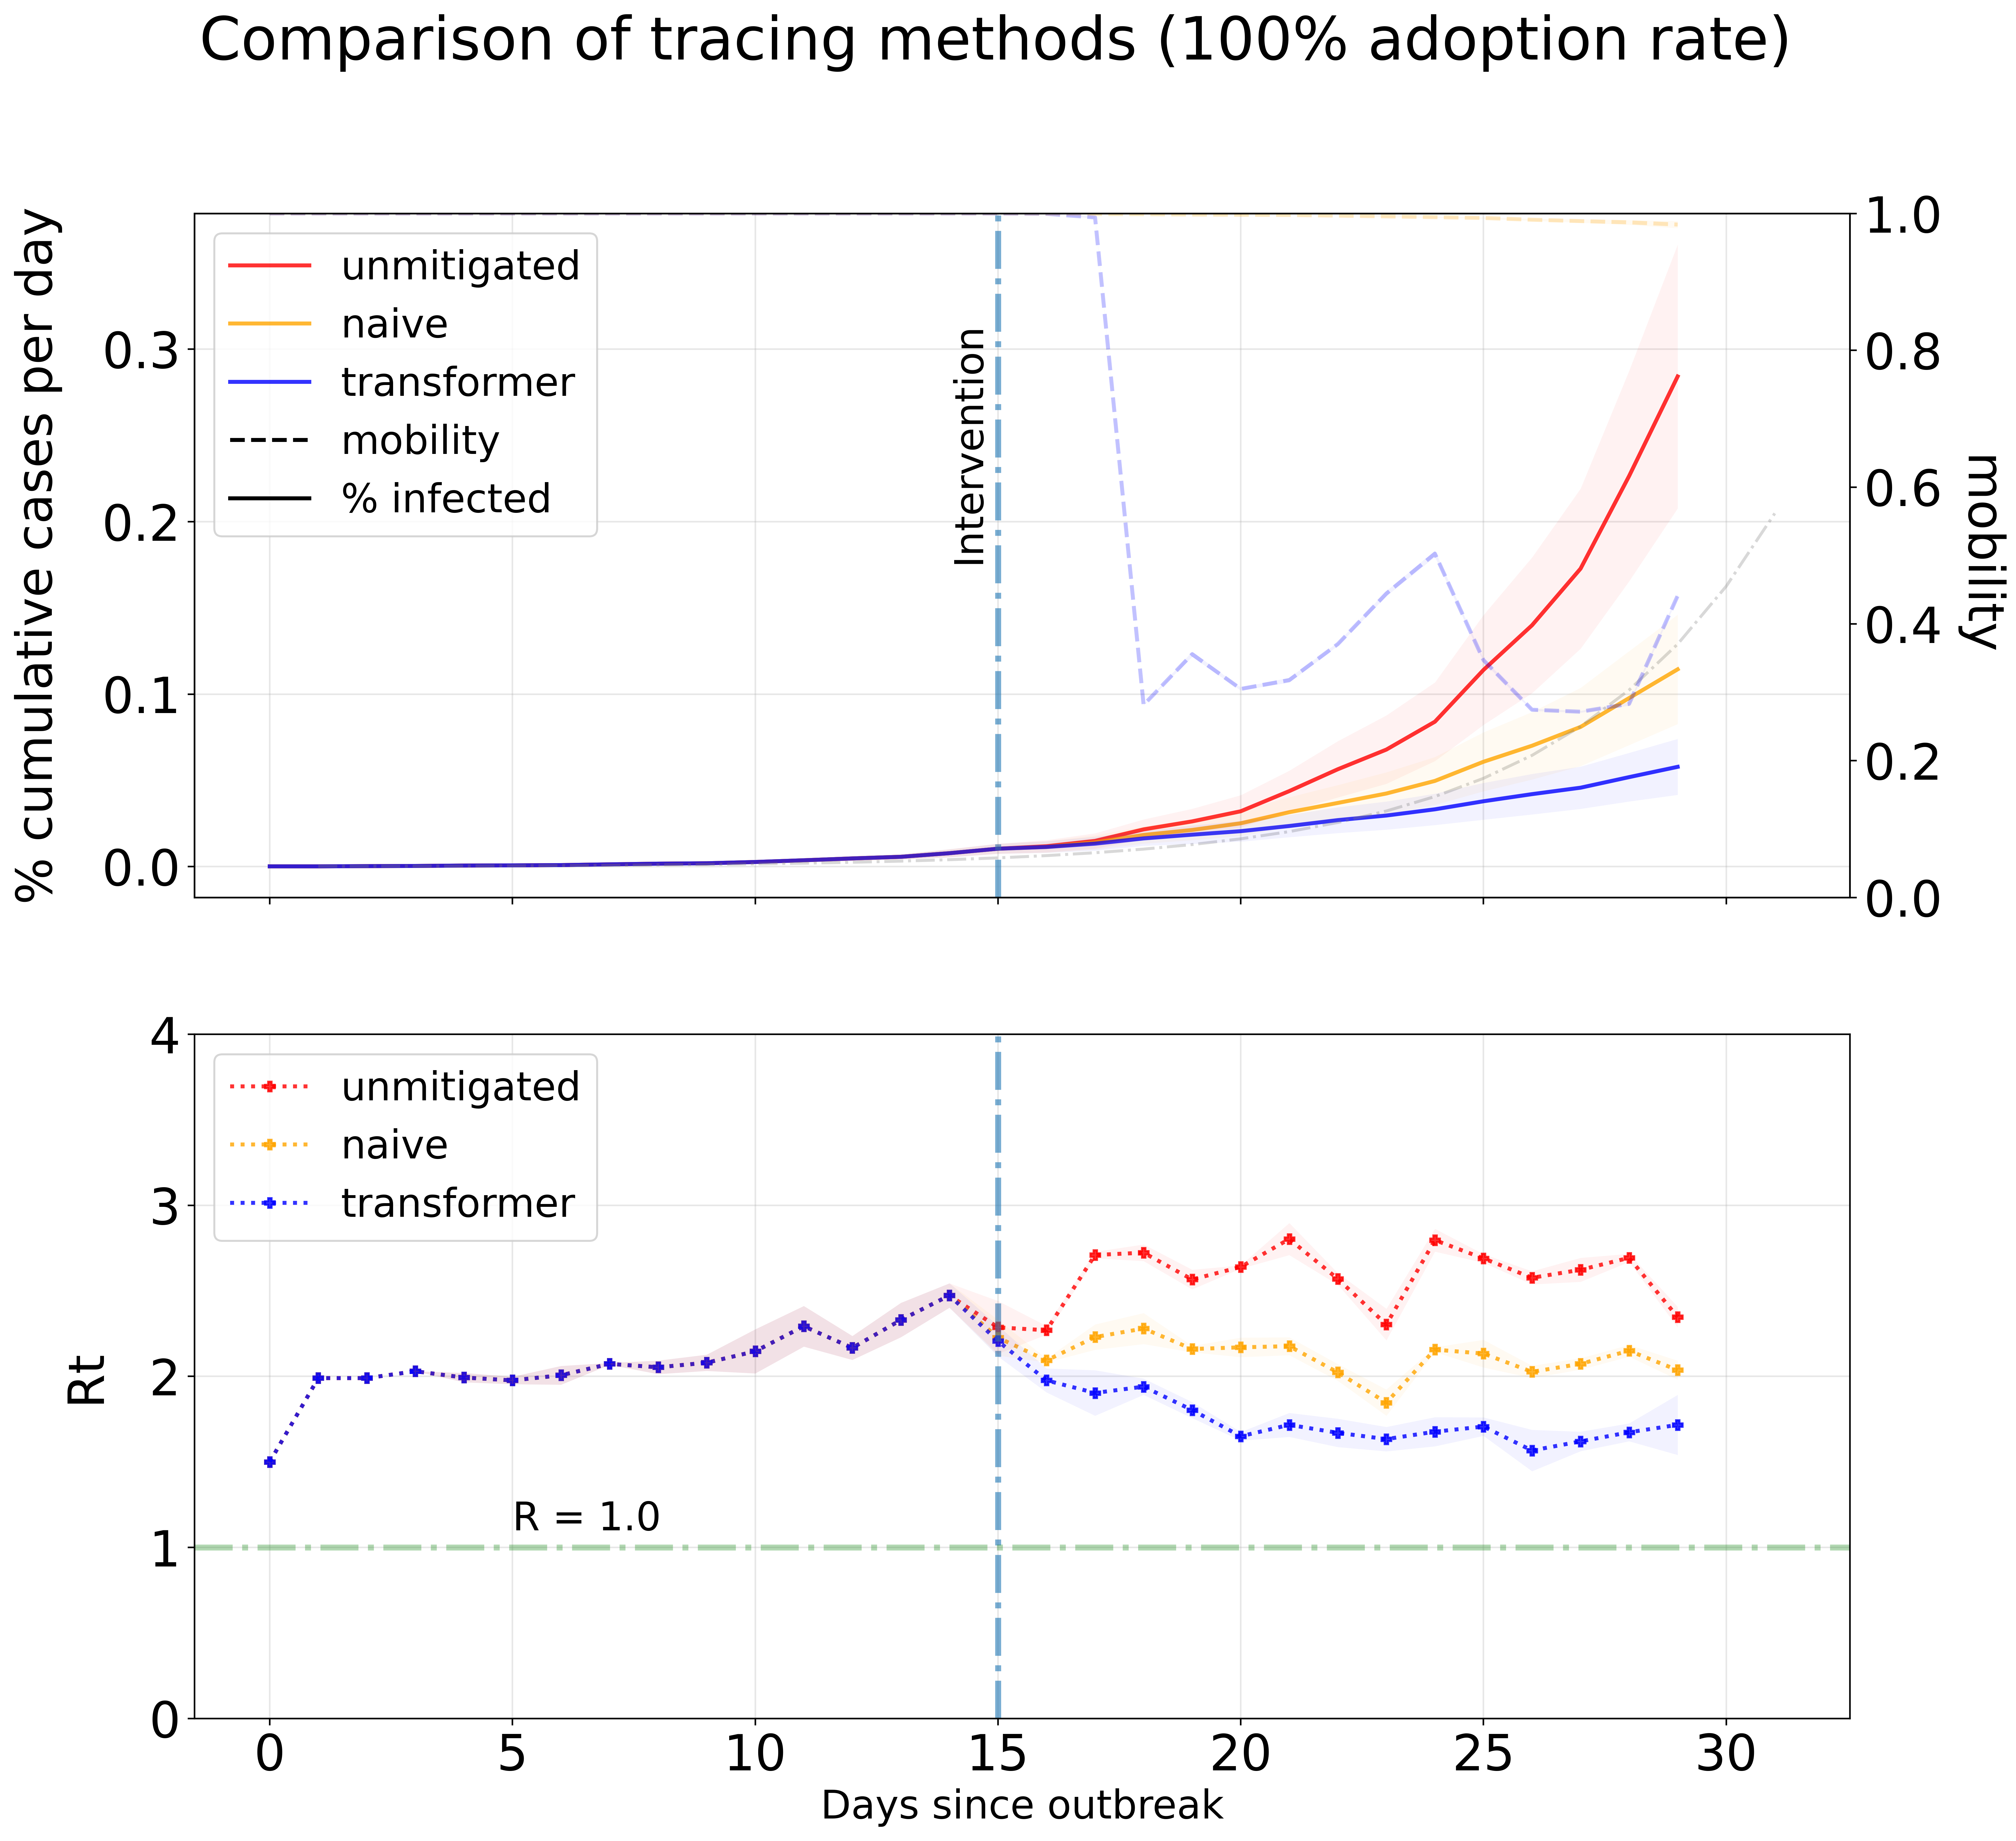

In [7]:
filenames = [filenames_unmitigated, filenames_naive, filenames_transformer]
labels = ["unmitigated", "naive", "transformer"]

fig = plot_all(filenames=filenames, labels=labels)
# fig.savefig("comparison_plots.pdf")
fig